In [8]:
"""
This block plots performance from entire experiments directory for something like a hyperparameter sweep.
"""
import os
import json
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn
from lib.models import ConvLayerNorm, Block
import matplotlib.pyplot as plt

data = []
from tqdm import tqdm

experiments_dir = f'./experiments'

for experiment in tqdm(os.listdir(experiments_dir)):
    base_f1s = []
    target_f1s = []
    folds = []

    for run in os.listdir(f'{experiments_dir}/{experiment}'):
        if not os.path.exists(f'{experiments_dir}/{experiment}/{run}/metrics.json'):
            continue
        metrics = json.load(open(f'{experiments_dir}/{experiment}/{run}/metrics.json'))
        losses = json.load(open(f'{experiments_dir}/{experiment}/{run}/losses.json'))
        hyperparameters = json.load(open(f'{experiments_dir}/{experiment}/{run}/hyperparameters.json'))

        data.append({
            'batch_size': hyperparameters['batch_size'], 
            'fold': run, 
            'best_custom_model_on_target_val_f1': metrics['best_target_model_target_val_f1'], 
            'mode': hyperparameters['mode'], 
            'target_data_pct': hyperparameters['target_data_pct'], 
            'best_custom_model_on_target_val_loss': metrics['best_target_model_target_val_loss']
        })
        
df = pd.DataFrame(data)

100%|██████████| 8/8 [00:00<00:00, 883.48it/s]


In [9]:
df

,batch_size,fold,best_custom_model_on_target_val_f1,mode,target_data_pct,best_custom_model_on_target_val_loss
0,256,fold1_asfik,0.899261,target_only,0.5,0.084344
1,256,fold0_tonmoy,0.885732,target_only,0.5,0.065913
2,128,fold1_asfik,0.885761,target_only,1.0,0.069494
3,128,fold0_tonmoy,0.946445,target_only,1.0,0.042883
4,128,fold1_asfik,0.931457,target_only,0.5,0.046939
5,128,fold0_tonmoy,0.928594,target_only,0.5,0.052945
6,64,fold1_asfik,0.895017,target_only,1.0,0.063882
7,64,fold0_tonmoy,0.946445,target_only,1.0,0.053498
8,32,fold1_asfik,0.941676,target_only,1.0,0.040106
9,32,fold0_tonmoy,0.944730,target_only,1.0,0.040959


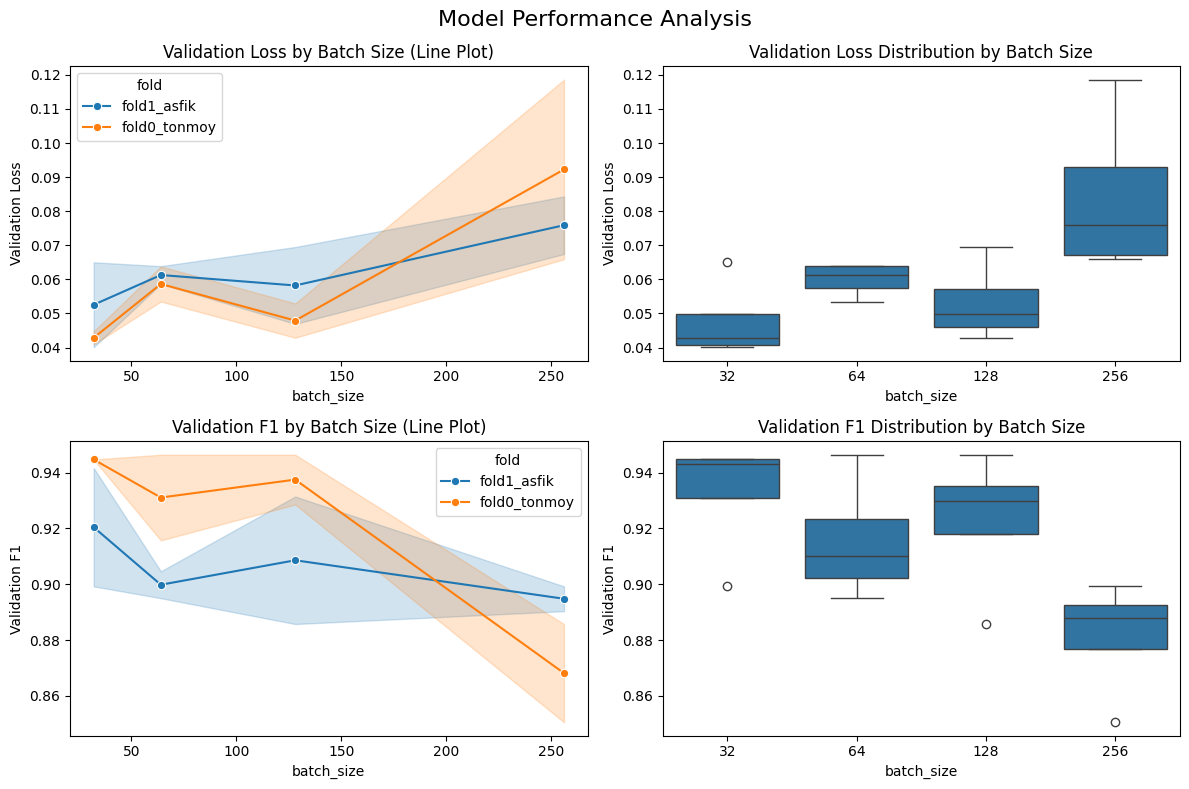

100%|██████████| 8/8 [00:00<00:00, 1478.36it/s]


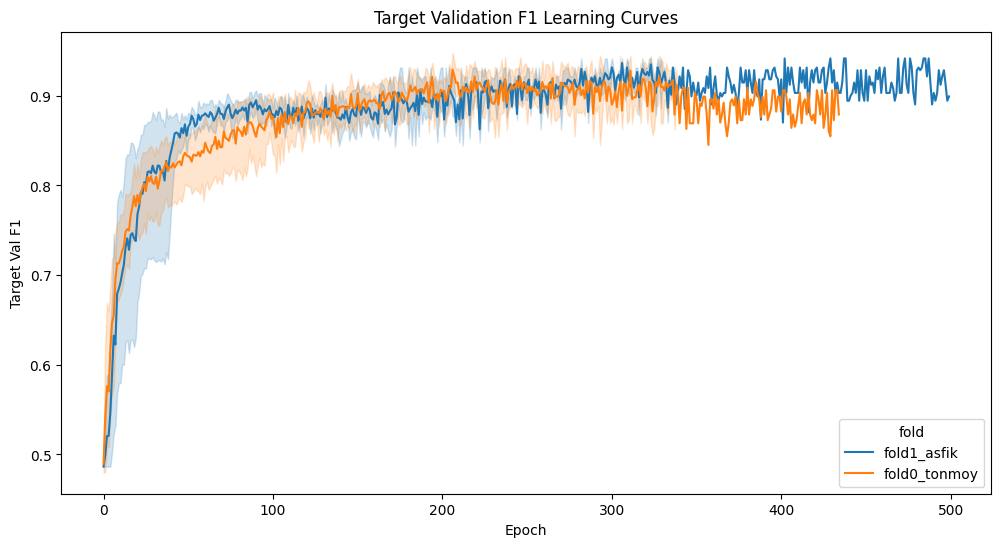

In [10]:
# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Model Performance Analysis', fontsize=16)

# Loss plots
sns.lineplot(data=df, x='batch_size', y='best_custom_model_on_target_val_loss', 
             hue='fold', marker='o', ax=axes[0, 0])
axes[0, 0].set_title('Validation Loss by Batch Size (Line Plot)')
axes[0, 0].set_ylabel('Validation Loss')

sns.boxplot(data=df, x='batch_size', y='best_custom_model_on_target_val_loss', ax=axes[0, 1])
axes[0, 1].set_title('Validation Loss Distribution by Batch Size')
axes[0, 1].set_ylabel('Validation Loss')

# F1 plots
sns.lineplot(data=df, x='batch_size', y='best_custom_model_on_target_val_f1', 
             hue='fold', marker='o', ax=axes[1, 0])
axes[1, 0].set_title('Validation F1 by Batch Size (Line Plot)')
axes[1, 0].set_ylabel('Validation F1')

sns.boxplot(data=df, x='batch_size', y='best_custom_model_on_target_val_f1', ax=axes[1, 1])
axes[1, 1].set_title('Validation F1 Distribution by Batch Size')
axes[1, 1].set_ylabel('Validation F1')

plt.tight_layout()
plt.show()

# Target val f1 learning curves
curve_data = []
for experiment in tqdm(os.listdir(experiments_dir)):
    for run in os.listdir(f'{experiments_dir}/{experiment}'):
        if not os.path.exists(f'{experiments_dir}/{experiment}/{run}/losses.json'):
            continue
        losses = json.load(open(f'{experiments_dir}/{experiment}/{run}/losses.json'))

        for epoch, f1 in enumerate(losses['target val f1']):
            curve_data.append({
                'epoch': epoch,
                'target_val_f1': f1,
                'fold': run
            })

curve_df = pd.DataFrame(curve_data)
plt.figure(figsize=(12, 6))
sns.lineplot(data=curve_df, x='epoch', y='target_val_f1', hue='fold')
plt.title('Target Validation F1 Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Target Val F1')
plt.show()


<Axes: xlabel='n_base_participants', ylabel='best_target_model_target_test_f1'>

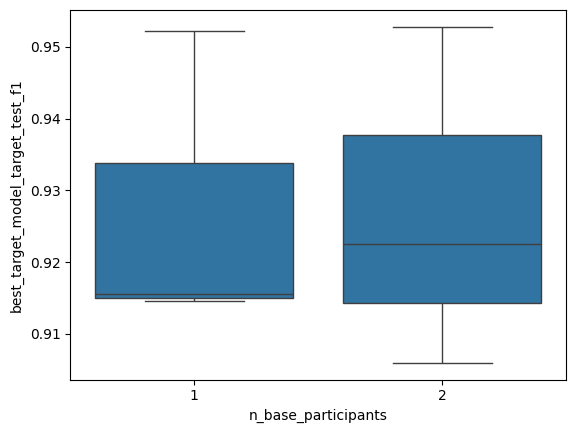

In [64]:
sns.boxplot(data=df, x='n_base_participants', y='best_target_model_target_test_f1')

<Axes: xlabel='n_base_participants', ylabel='best_target_model_target_test_f1'>

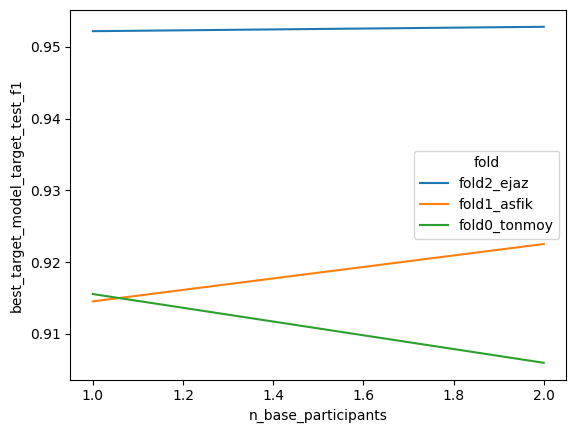

In [66]:
sns.lineplot(data=df, x='n_base_participants', y='best_target_model_target_test_f1',hue='fold')


In [ ]:

display(df)

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Model Performance Analysis', fontsize=16)

# Loss plots
sns.lineplot(data=df, x='batch_size', y='best_custom_model_on_target_val_loss', 
             hue='fold', marker='o', ax=axes[0, 0])
axes[0, 0].set_title('Validation Loss by Batch Size (Line Plot)')
axes[0, 0].set_ylabel('Validation Loss')

sns.boxplot(data=df, x='batch_size', y='best_custom_model_on_target_val_loss', ax=axes[0, 1])
axes[0, 1].set_title('Validation Loss Distribution by Batch Size')
axes[0, 1].set_ylabel('Validation Loss')

# F1 plots
sns.lineplot(data=df, x='batch_size', y='best_custom_model_on_target_val_f1', 
             hue='fold', marker='o', ax=axes[1, 0])
axes[1, 0].set_title('Validation F1 by Batch Size (Line Plot)')
axes[1, 0].set_ylabel('Validation F1')

sns.boxplot(data=df, x='batch_size', y='best_custom_model_on_target_val_f1', ax=axes[1, 1])
axes[1, 1].set_title('Validation F1 Distribution by Batch Size')
axes[1, 1].set_ylabel('Validation F1')

plt.tight_layout()
plt.show()
